# Long Notebook - Active

#### Emil B. Berglund - 529222 & Louis H. H. Linnerud - 539305, Team: Noe Lættis 

#### Table of contents:
1. Exploratory data analysis
2. Feature Engineering 
3. Models/Predictors
    - LightGBM
    - Random Forest Regressor
4. Model Interpretations
    - feature importance
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
import catboost as cb
import featuretools as ft
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder


#from pandas_profiling import ProfileReport

In [267]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [268]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


#### Domain Knowledge

Retailers obviously earn their revenue from sales, different retailers sell different products to different customers. Different products have different margins and number of sales, directly impacting the revenue. Number of sales most likely have a high correlation with number of costumers, areas with a high population density will therefor most likely have a higher number of customers, impacting number of sales and then impacting the revenue. Therefor retailer type and geographical position most likely have a high impact on revenue. Only knowing those two attributes can be a good pin pointer, but not necessary enough as described in this article: https://carto.com/blog/retail-revenue-prediction-data-science/. Area infrastructure, retailer reputation, market competition, inventory managements, customer type, sales strategy and a lot more factors impact revenue and makes this problem complex. further reading on some of these factors: https://smallbusiness.chron.com/calculate-percentage-profit-markups-business-60099.html


#### Is the data intuitiv?

As can be seen below, data is organized in rows, where each row represents a single retailer with its relevant attributes and revenue. The stores train, extra and test data is intuitiv.

The different grunnkrets data was not super intuitv before some exploration was done, the same grunnkrets_id appeard more than once, but we shortly realized that this is because the measurment (example: average income) is done twice, once in 2015 and once in 2016.

In [269]:
stores_train = pd.read_csv('data/stores_train.csv')


In [270]:
stores_train.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

In [271]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [272]:
stores_train.describe()

year  grunnkrets_id           lat           lon       revenue
count  12859.0   1.285900e+04  12859.000000  12859.000000  12859.000000
mean    2016.0   9.338697e+06     61.212166      9.995425      8.220683
std        0.0   5.788875e+06      2.965672      3.793565     15.377130
min     2016.0   1.010105e+06     57.994443      4.625889      0.000000
25%     2016.0   3.014208e+06     59.421935      7.284691      1.195000
50%     2016.0   9.065213e+06     59.939017     10.407916      3.374000
75%     2016.0   1.449011e+07     62.116531     10.848180      7.996000
max     2016.0   2.030031e+07     71.098287     31.118935    219.599000

In [273]:
#report = ProfileReport(stores_train)
#report

#### Explore individual features and pairs and groups

Explore revenue based on store type

In [274]:
len(stores_train.plaace_hierarchy_id.unique())

91

In [275]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

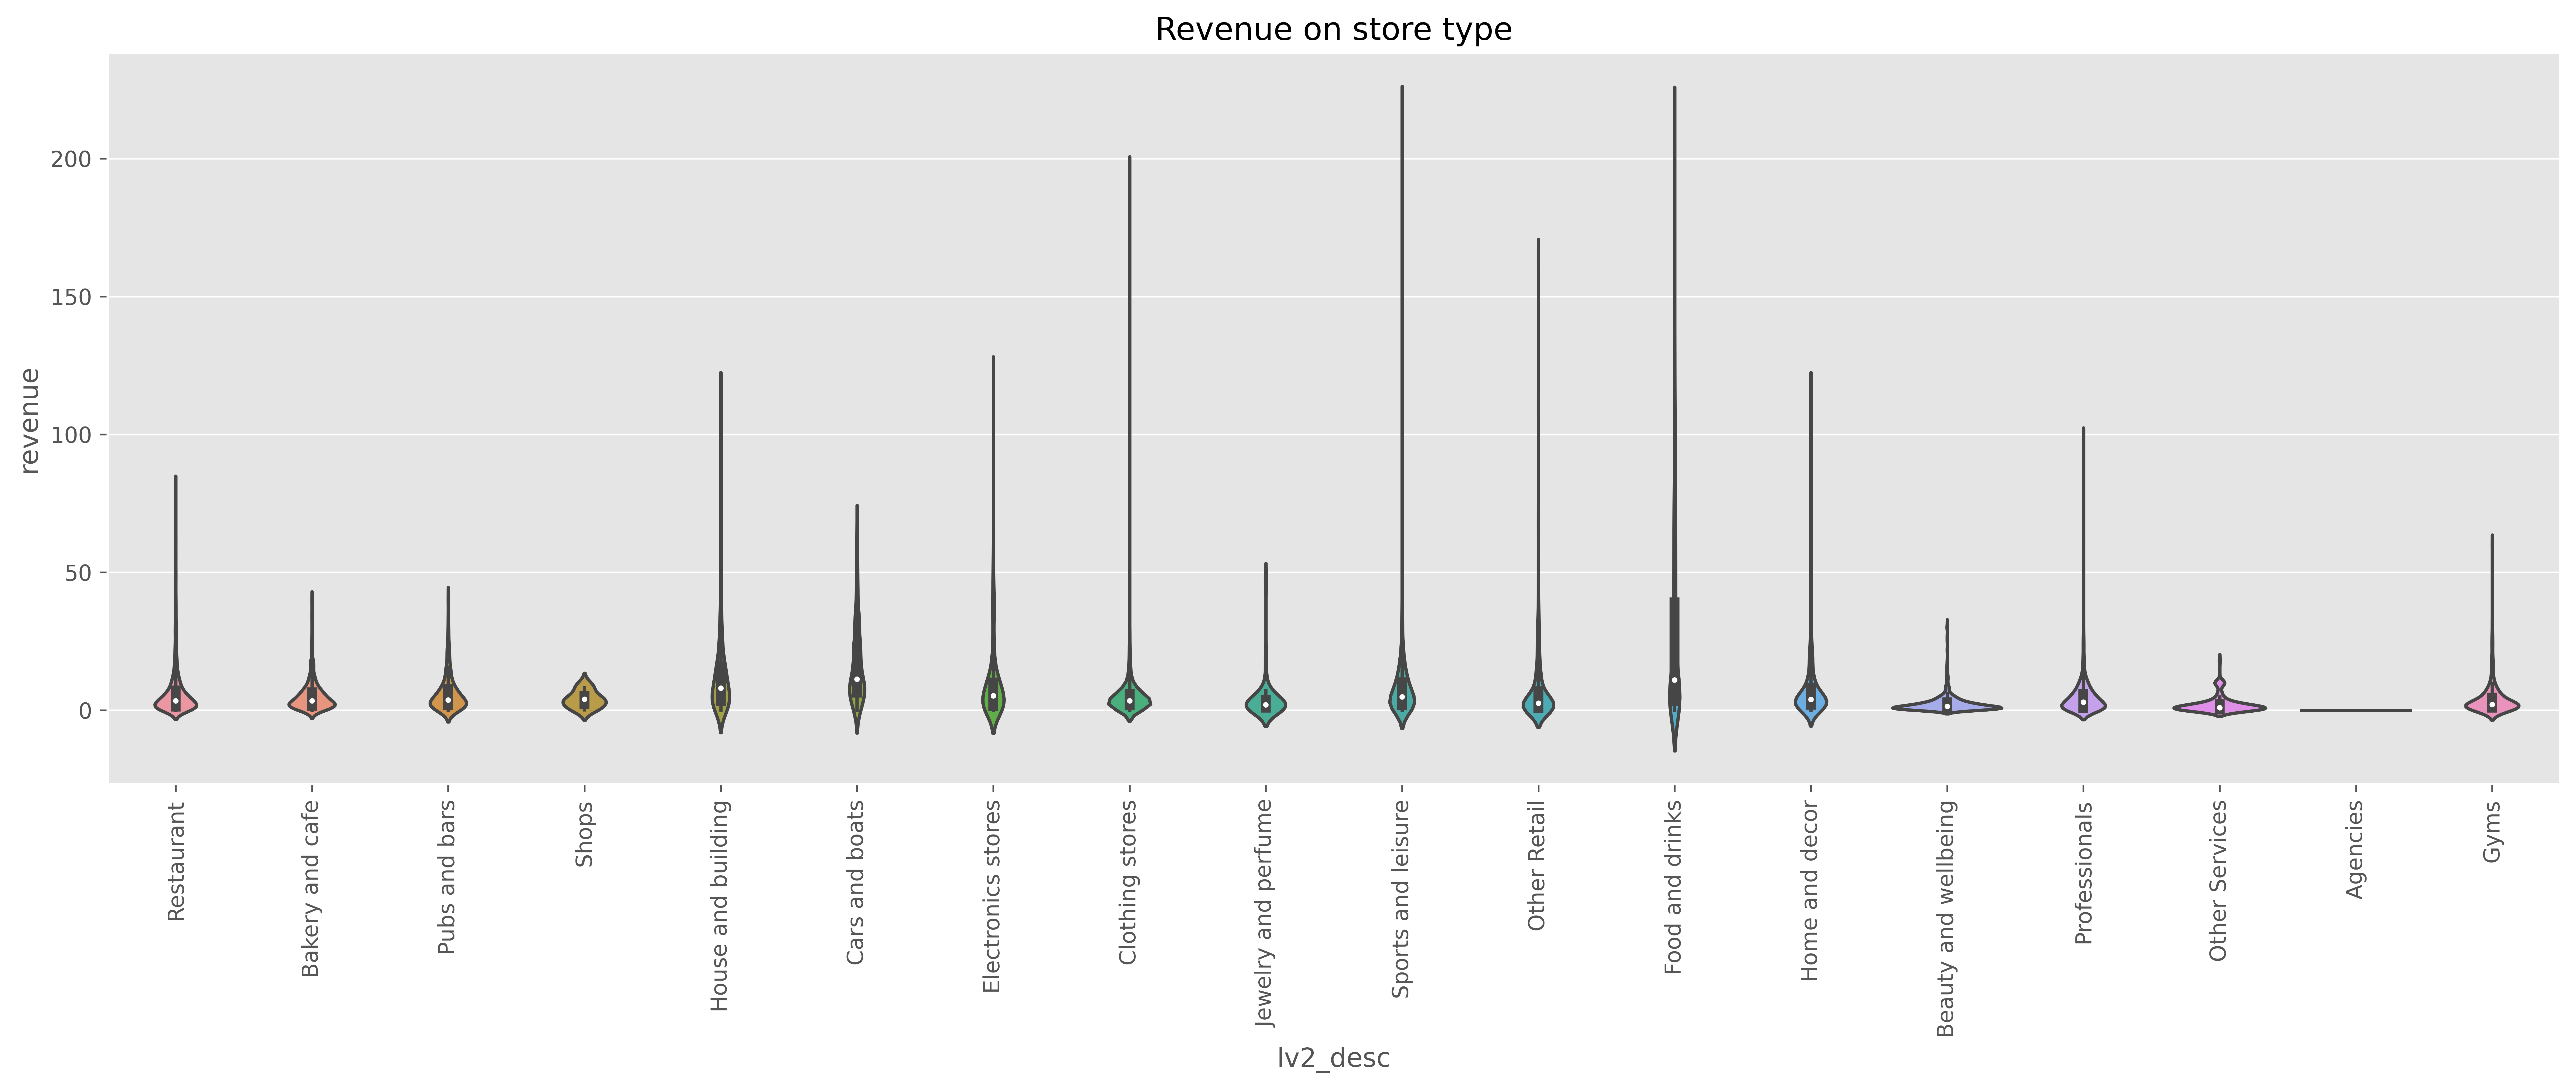

In [276]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [277]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

store_id  year                     store_name  \
12442  915797512-915815782-782390  2016  RUUKKI BUILDING COMPONENTS AS   

      plaace_hierarchy_id  sales_channel_name_x  grunnkrets_id  \
12442             3.5.3.0  Advertising agencies        3014005   

                  address        lat        lon chain_name  ... revenue  \
12442  ØSTRE AKER VEI 219  59.948112  10.883745        NaN  ...     0.0   

       sales_channel_name_y lv1  lv1_desc  lv2  lv2_desc    lv3  \
12442  Advertising agencies   3  Services  3.5  Agencies  3.5.3   

                   lv3_desc      lv4              lv4_desc  
12442  Advertising agencies  3.5.3.0  Advertising agencies  

[1 rows x 21 columns]

Further exploration of "Food and drink" type stores


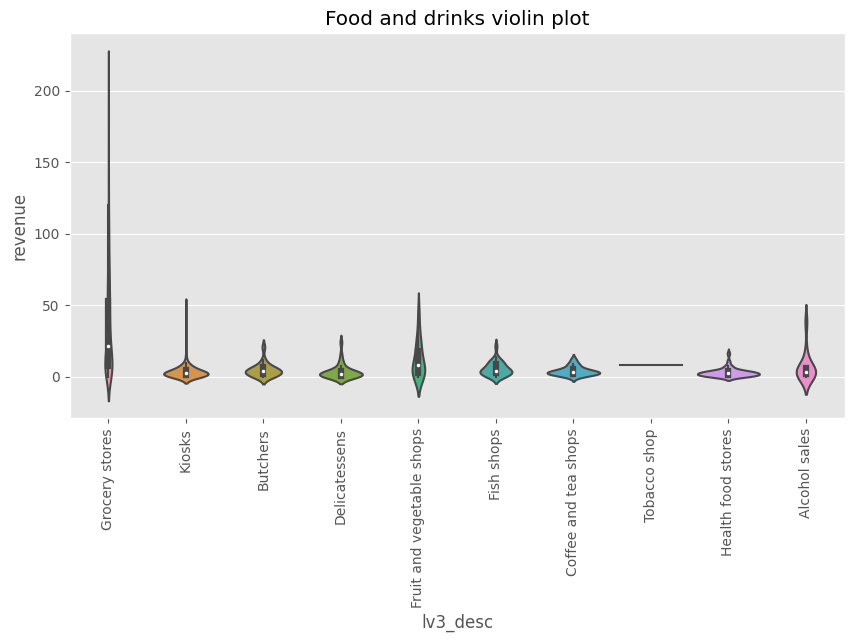

In [278]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with NaN, 0 or negative revenue

In [279]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

year  grunnkrets_id         lat         lon  revenue         lv1  \
count   217.0   2.170000e+02  217.000000  217.000000    217.0  217.000000   
mean   2016.0   7.609318e+06   60.671650   10.007769      0.0    1.788018   
std       0.0   5.511516e+06    2.432534    3.006842      0.0    0.594141   
min    2016.0   1.040301e+06   58.029041    5.035586      0.0    1.000000   
25%    2016.0   3.010401e+06   59.559941    8.591472      0.0    1.000000   
50%    2016.0   6.020802e+06   59.919065   10.620743      0.0    2.000000   
75%    2016.0   1.201012e+07   60.394286   10.814440      0.0    2.000000   
max    2016.0   2.030030e+07   69.890997   30.043801      0.0    3.000000   

              lv2  
count  217.000000  
mean     2.188940  
std      0.758634  
min      1.100000  
25%      1.100000  
50%      2.400000  
75%      2.800000  
max      3.600000

In [280]:
stores_with_hierarchy[stores_with_hierarchy["revenue"] < 0.0].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

In [281]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]== np.nan].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the long tail to the right of the major distribution.
The data is clearly positively skewed, confirmed by the skew number printed above the plot

raw data skew: 4.759845139718512
log transform skew: 0.6787855811421601


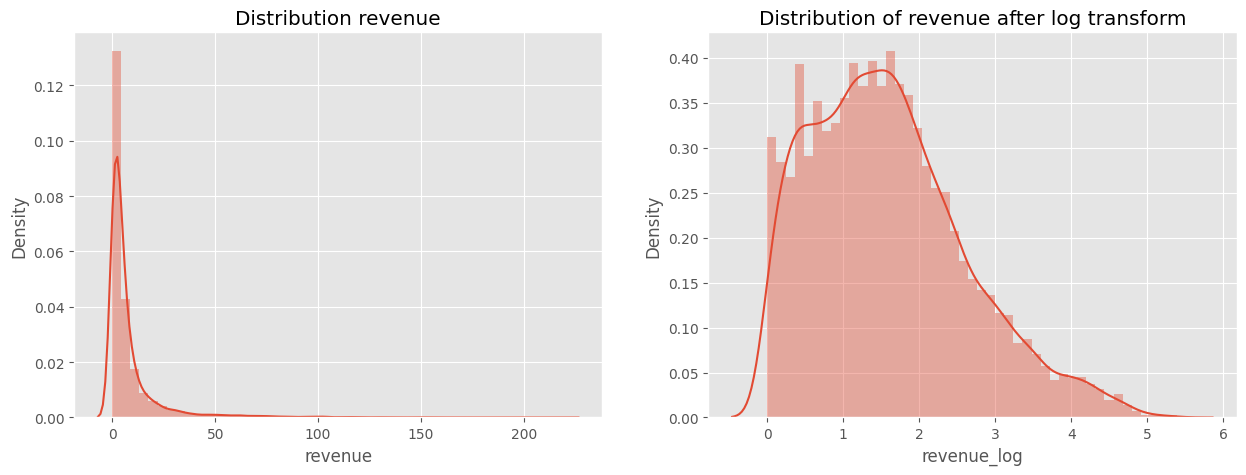

In [282]:
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(stores_train['revenue'], ax=ax1);
ax1.set_title('Distribution revenue');
sns.distplot(rev_log['revenue_log'], ax=ax2);
ax2.set_title('Distribution of revenue after log transform');

print(f"raw data skew: {stores_train['revenue'].skew()}")
print(f"log transform skew: {rev_log['revenue_log'].skew()}")

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [283]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [284]:
remove_columns(stores_train,['year'])
stores_train.head()

store_id                           store_name  \
0   983540538-974187930-44774  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

#### Remove retailers with 0 revenue function - might be handy

In [285]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

Below is before trimming

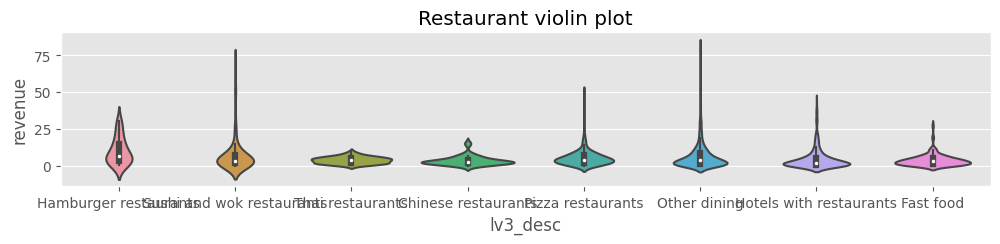

In [286]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

Cap-outliers-function for the relationship between store type and revenue

In [287]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    col_idx = stores.columns.get_loc('revenue')
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
        
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index,[col_idx]] = upper_treshold
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index,[col_idx]] = lower_treshold
        
    

In [288]:
stores_train = pd.read_csv('data/stores_train.csv')
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


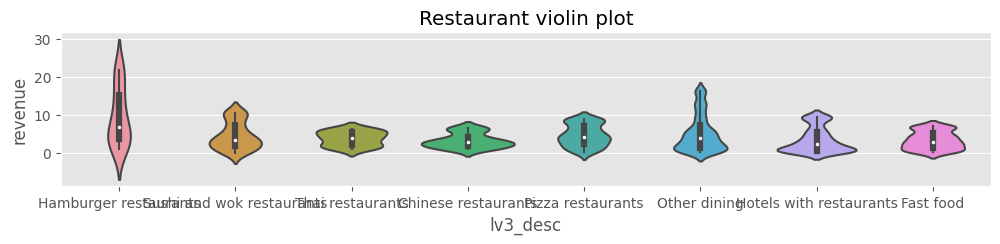

In [289]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()
    break #comment out for exploring more store types

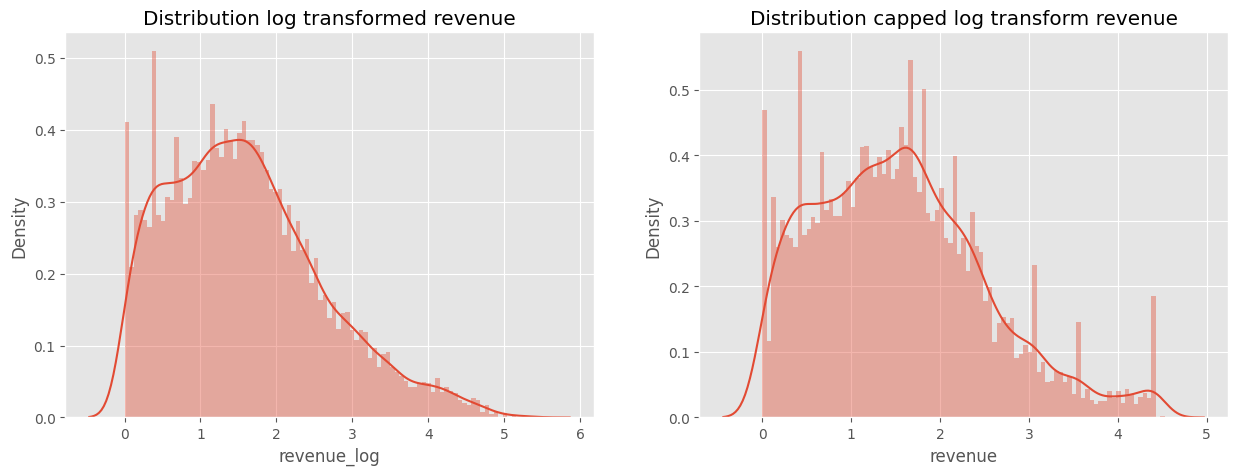

In [290]:
stores_train = pd.read_csv('data/stores_train.csv')
rev_log = pd.DataFrame()
rev_log['revenue_log'] = np.log1p(stores_train['revenue'])

rev_capped_log = stores_train.copy()
quantile_storeType_vs_revenue(rev_capped_log, 0.00, 0.90)
rev_capped_log['revenue'] = np.log1p(rev_capped_log['revenue'])

fig, (ax1, ax2) = plt.subplots(figsize=(15, 5), ncols=2, dpi=100)
sns.distplot(rev_log['revenue_log'], ax=ax1, bins=91);
ax1.set_title('Distribution log transformed revenue');
sns.distplot(rev_capped_log['revenue'], ax=ax2, bins=91);
ax2.set_title('Distribution capped log transform revenue');

Quantiling the data improved our predictions greatly in the beginning of the project, but we saw that it didnt have a noticable impact after we began exploring log transform, the plot above shows that quantiling does not improve distribution with log transform

#### comparing test set to training set

In [291]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

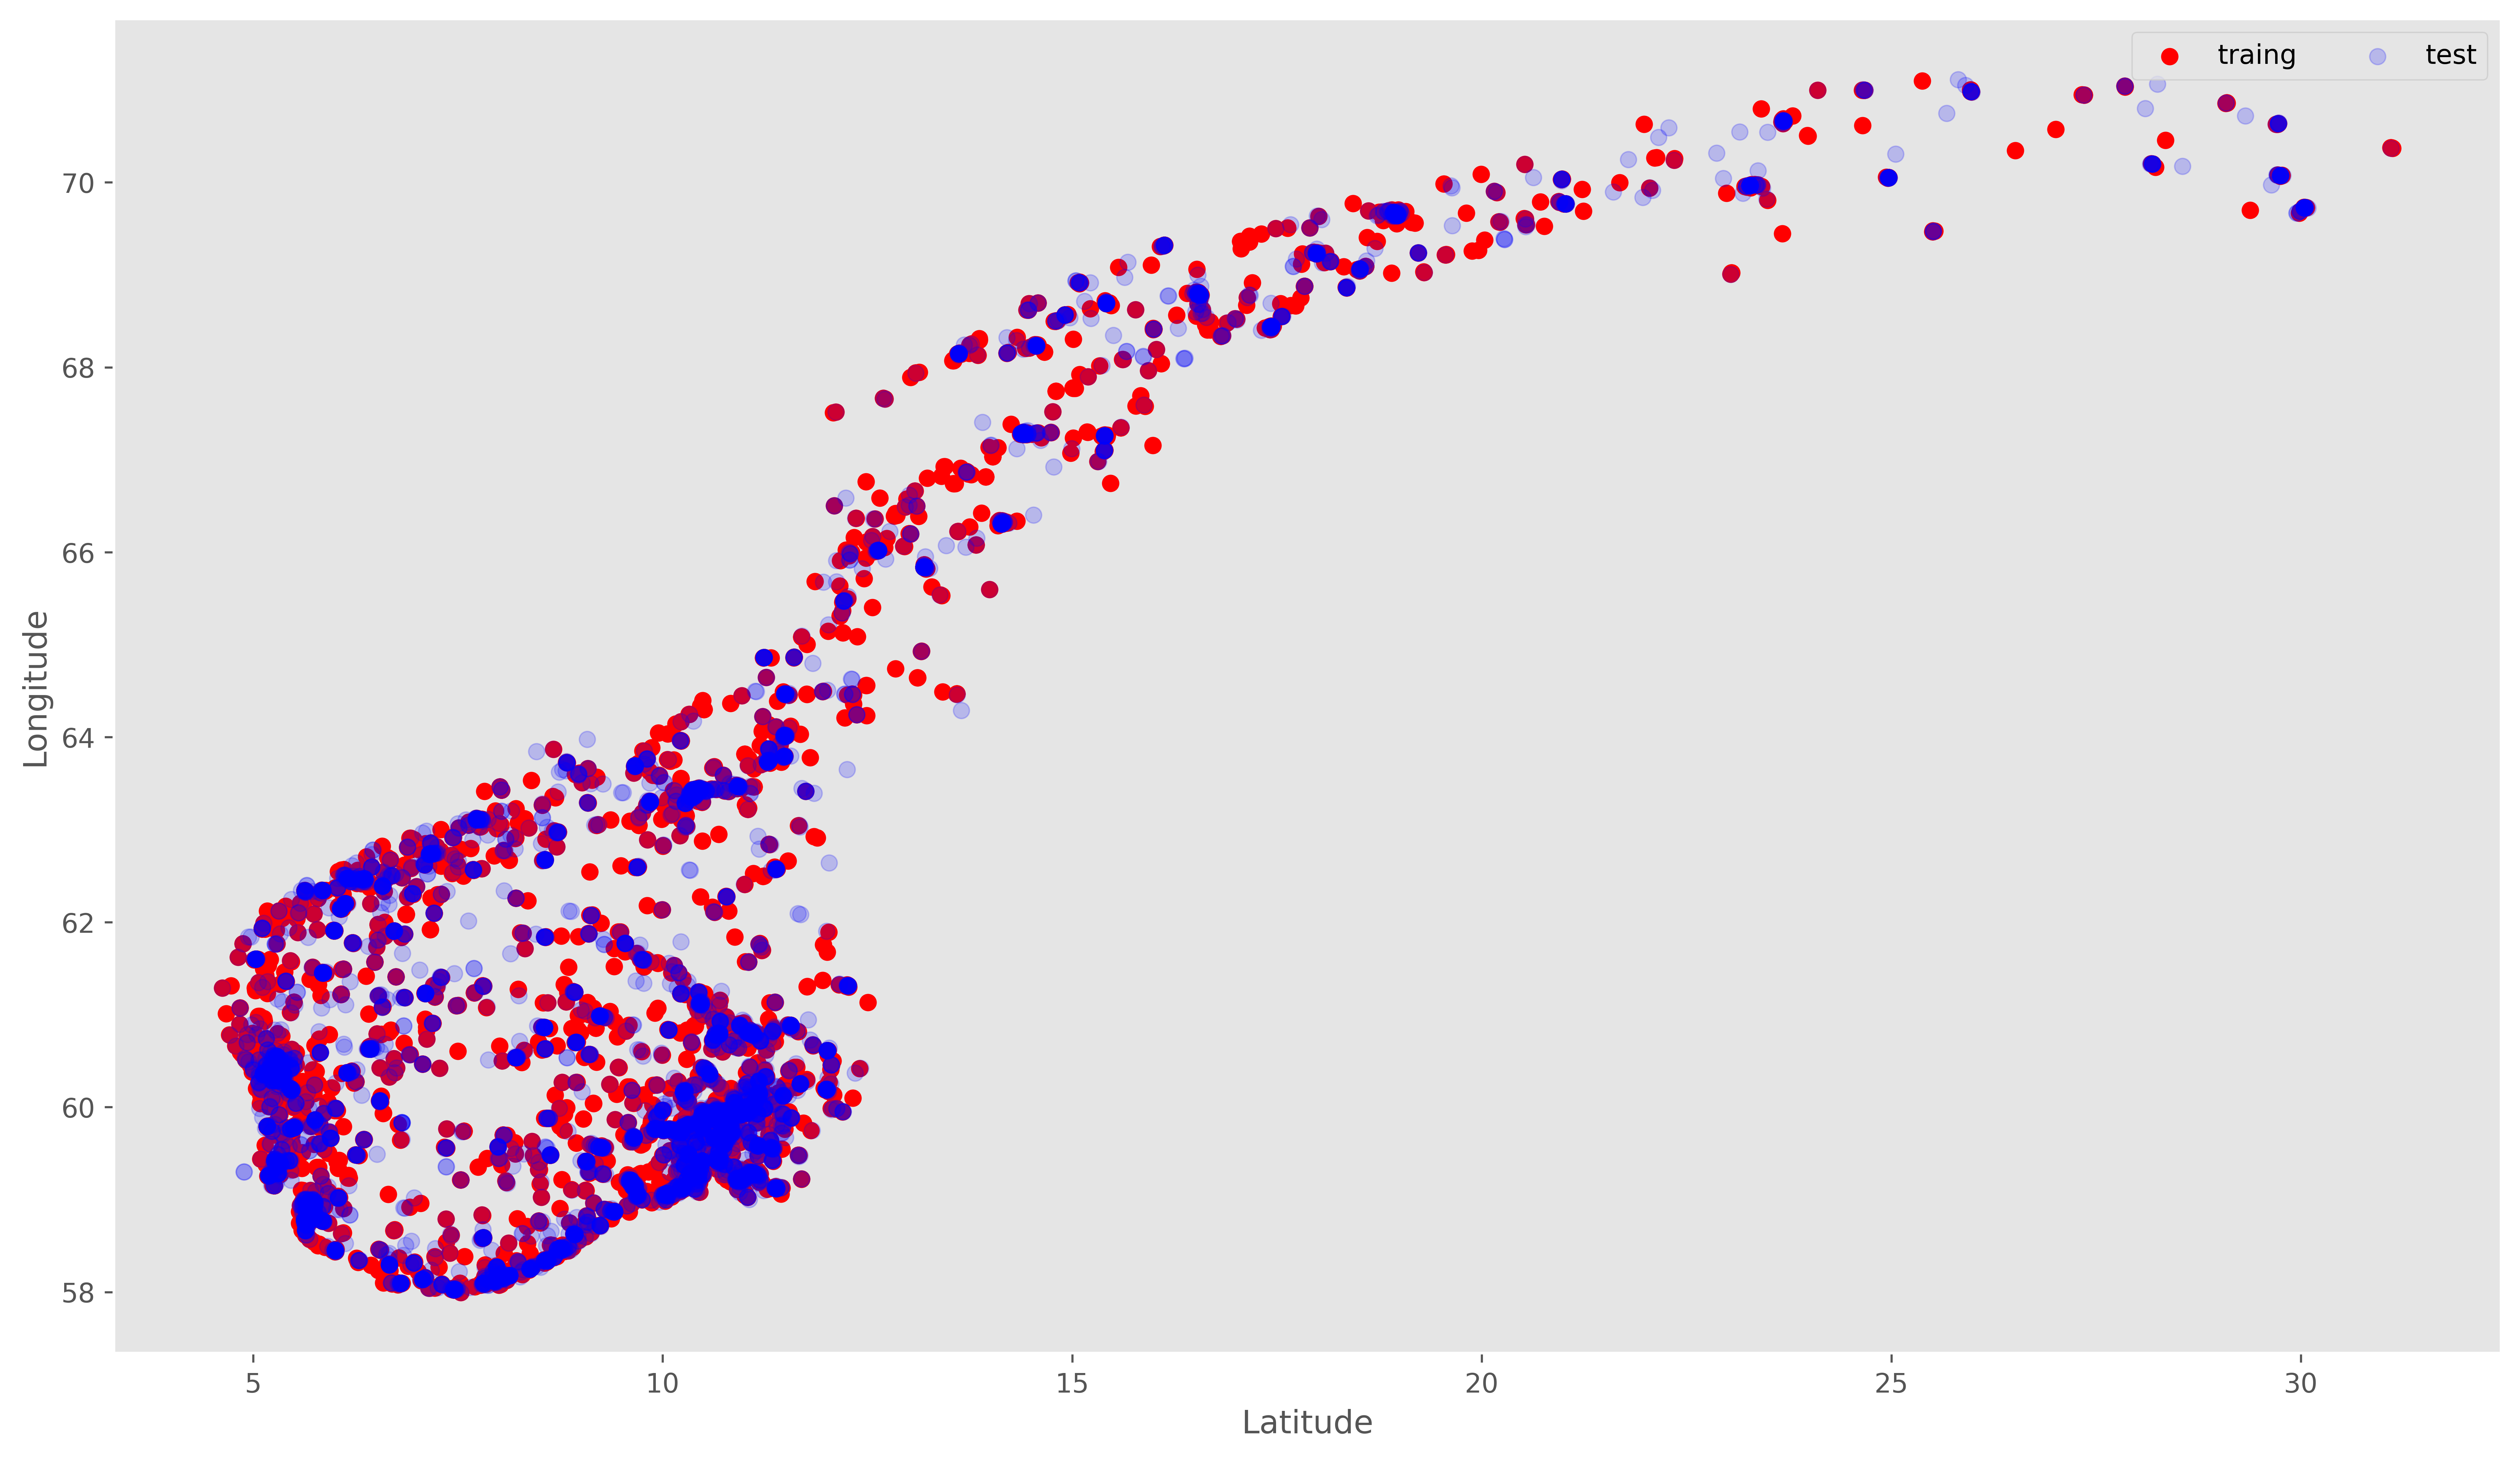

In [292]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



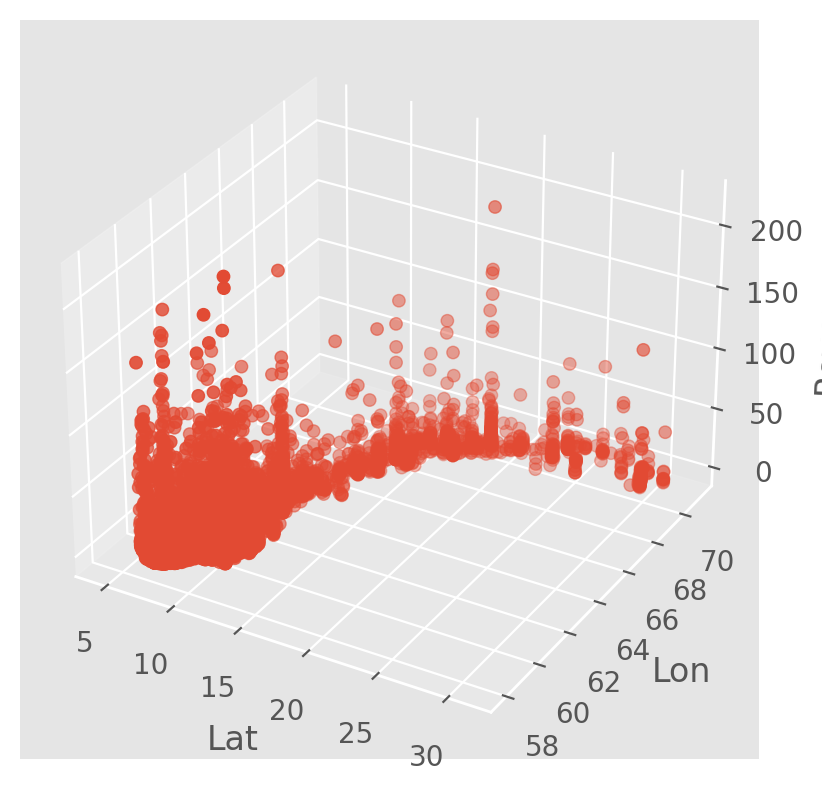

In [293]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lon'],stores_train['lat'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [294]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.head()

store_id_x  year_x         store_name  \
0   988143294-888170332-16561    2016         YAYAS OSLO   
1  994905953-994946978-500374    2016         YAYAS OSLO   
2   913243730-871762422-46032    2016    MING RESTAURANT   
3  913594053-913748263-697094    2016   ALLEGRO PIZZERIA   
4    981126610-981131126-5363    2016  SPISERIET TRIADEN   

  plaace_hierarchy_id_x sales_channel_name_x  grunnkrets_id_x  \
0               1.1.3.0     Thai restaurants          3010905   
1               1.1.3.0     Thai restaurants          3010905   
2               1.1.4.0  Chinese restaurants          5010602   
3               1.1.5.0    Pizza restaurants         19021405   
4               1.1.6.2          Restaurants          2300312   

              address_x      lat_x      lon_x chain_name_x  ... year_y  \
0       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
1       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
2          STORGATA 130  61.120842  10.461641          NaN  ...   2016   
3     SOLSTRANDVEGEN 47  69.639962  18.970862          NaN  ...   2016   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195          NaN  ...   2016   

  plaace_hierarchy_id_y  sales_channel_name_y grunnkrets_id_y  \
0               1.1.3.0      Thai restaurants         3010301   
1               1.1.3.0      Thai restaurants         3010301   
2               1.1.4.0   Chinese restaurants         1040504   
3               1.1.5.0     Pizza restaurants        19021404   
4               1.1.6.2           Restaurants         2300312   

              address_y      lat_y      lon_y  chain_name_y  \
0   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
1   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
2   DRONNINGENS GATE 27  59.435418  10.659777           NaN   
3        TURISTVEGEN 19  69.646103  18.991212           NaN   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195           NaN   

                    mall_name_y revenue  
0                           NaN   9.233  
1                           NaN   9.233  
2                           NaN   6.484  
3                           NaN   4.609  
4  Triaden Lørenskog Storsenter   5.147  

[5 rows x 22 columns]

### Explore the other data sets

In [295]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                             NaN   
3  d9cda2c7-355a-49c1-b56c-a33180d2a82e                             NaN   
4  f803bcd3-182d-450b-bbb4-113c6ca885c2                             NaN   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   
3  Mangler viktighetsnivå     MIDDLE_LEFT   
4  Mangler viktighetsnivå    MIDDLE_RIGHT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)  
3  POINT(10.7781496457324 59.9301044643692)  
4  POINT(10.7781676444854 59.9302099995898)

In [296]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

grunnkrets_id  year     grunnkrets_name          district_name  \
0       10010701  2015      Grim-Dueknipen  Grim-Møllevann-Dalane   
1       10010803  2015  Kvadraturen sørøst         Kvadraturen-Eg   
2       10020608  2015            Ormestad                  Holum   
3       10020901  2015              Tregde        Tregde-Skjernøy   
4       10030210  2015           Bryneheia             Vanse/Åpta   

  municipality_name                                           geometry  \
0      Kristiansand  MULTIPOLYGON(((7.97199691121304 58.14336769560...   
1      Kristiansand  POLYGON((8.00234207061135 58.1443514886041, 8....   
2            Mandal  POLYGON((7.48512808482995 58.0374976883392, 7....   
3            Mandal  MULTIPOLYGON(((7.50996051810658 58.02134863868...   
4           Farsund  POLYGON((6.70396719073296 58.0877854965615, 6....   

   area_km2  
0  0.768961  
1  0.361355  
2  0.280188  
3  0.156311  
4  0.791894

In [297]:
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_incomes.head()

grunnkrets_id  year  all_households  singles  couple_without_children  \
0       14200105  2016          551700   270300                        0   
1        2311202  2015          577700   311800                        0   
2        2310501  2015          668800   292500                        0   
3       14200401  2016          507000   250700                        0   
4       14200105  2015          539900   275800                        0   

   couple_with_children  other_households  single_parent_with_children  
0                     0                 0                            0  
1                682300                 0                            0  
2                842000                 0                            0  
3                     0                 0                            0  
4                710300                 0                            0

In [298]:
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_households.head()

grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  
0        4  
1        3  
2        7  
3        0  
4        4

In [299]:
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
gk_ages.head()

grunnkrets_id  year  age_0  age_1  age_2  age_3  age_4  age_5  age_6  \
0       16013117  2015     14     14     14     14     13     13     12   
1       16013117  2016     10     10     10     10     10     10      9   
2       11030206  2015      5      5      5      5      5      4      4   
3       16011203  2016      2      2      2      2      2      3      3   
4        3011601  2016      7      7      7      7      6      6      5   

   age_7  ...  age_81  age_82  age_83  age_84  age_85  age_86  age_87  age_88  \
0     11  ...       0       0       0       0       0       0       0       0   
1      9  ...       0       0       0       0       0       0       0       0   
2      3  ...       0       0       0       0       0       0       0       0   
3      3  ...       1       1       1       1       1       1       1       0   
4      4  ...       1       1       0       0       0       0       0       0   

   age_89  age_90  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 93 columns]

# ___________ _2. Feature Engineering_ ___________

In [300]:
stores_train = pd.read_csv('data/stores_train.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
buss_stopps = pd.read_csv('data/busstops_norway.csv')

grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_incomes.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_households.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_ages.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
buss_stopps.drop_duplicates(subset=['busstop_id'], inplace=True)



Ages

In [301]:
# number of people in grunnkrets
gk_ages['tot_people'] = np.sum(gk_ages.iloc[:,np.arange(2,93,1)], axis=1)
gk_ages.head()

# people density (number of people divided by arekm2)
gk_area = grunnkrets[['grunnkrets_id','area_km2']]
gk_ages = pd.merge(gk_ages, gk_area, how='left', on='grunnkrets_id')
gk_ages['people_density'] = (gk_ages['tot_people'] / gk_ages['area_km2'])
gk_ages['people_density_log'] = np.log1p(gk_ages['tot_people'] / gk_ages['area_km2'])

gk_ages.head()



grunnkrets_id  year  age_0  age_1  age_2  age_3  age_4  age_5  age_6  \
0       16013117  2015     14     14     14     14     13     13     12   
1       11030206  2015      5      5      5      5      5      4      4   
2       16011203  2016      2      2      2      2      2      3      3   
3        3011601  2016      7      7      7      7      6      6      5   
4        3010308  2015      7      7      7      7      7      6      6   

   age_7  ...  age_85  age_86  age_87  age_88  age_89  age_90  tot_people  \
0     11  ...       0       0       0       0       0       0        1075   
1      3  ...       0       0       0       0       0       0         508   
2      3  ...       1       1       1       0       0       0         880   
3      4  ...       0       0       0       0       0       0         645   
4      5  ...       1       1       0       0       0       0         838   

   area_km2  people_density  people_density_log  
0  0.080968    13276.775063            9.493847  
1  0.081412     6239.892860            8.738879  
2  0.095402     9224.102158            9.129684  
3  0.033981    18981.134917            9.851254  
4  0.060394    13875.630626            9.537961  

[5 rows x 97 columns]

Households

In [302]:
# Number of house holds
gk_households['nb_households']  = np.sum(gk_households.iloc[:,np.arange(2,10,1)], axis=1)
gk_households.head()




grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  nb_households  
0        4              8  
1        3             10  
2        7             17  
3        0              0  
4        4             10

Buss stops

In [303]:
# Number of buss stops

# Add grunnkrets to busstop

Store set

In [304]:
def self_aggregate_columns (stores):
    # has mall ~ dropped "has_mall" as it had low impact seen in feature engineering plots
    #stores['mall_name'] = stores['mall_name'].fillna('0')
    #stores['has_mall'] = stores['mall_name'].apply(lambda x: 1 if x !='0' else 0)

    # has chain
    stores['chain_name'] = stores['chain_name'].fillna('0')
    stores['has_chain'] = stores['chain_name'].apply(lambda x: 1 if x !='0' else 0)

    # Distance to another store

    # Distance to another store of same type

    # Density of stores in grunnkrets
    #gk_area = grunnkrets[['grunnkrets_id','area_km2']]
    #st_dens = pd.merge(gk_ages, gk_area, how='left', on='grunnkrets_id')
    
        

    # lat lon log transform
    #stores['lat_log'] = np.log1p(stores['lat'])
    #stores['lon_log'] = np.log1p(stores['lon'])

Concat columns

In [305]:
def add_selected_columns(df):
    self_aggregate_columns(df)
    gk = grunnkrets[['grunnkrets_id','municipality_name']]
    gk_i = gk_incomes[['grunnkrets_id','all_households']] #all house holds = median income
    gk_h = gk_households[['grunnkrets_id','nb_households']]
    gk_a = gk_ages[['grunnkrets_id','tot_people','people_density_log']]
    
    concat = pd.merge(df, gk, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_i, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_h, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_a, how='left', on='grunnkrets_id')
    
    return concat

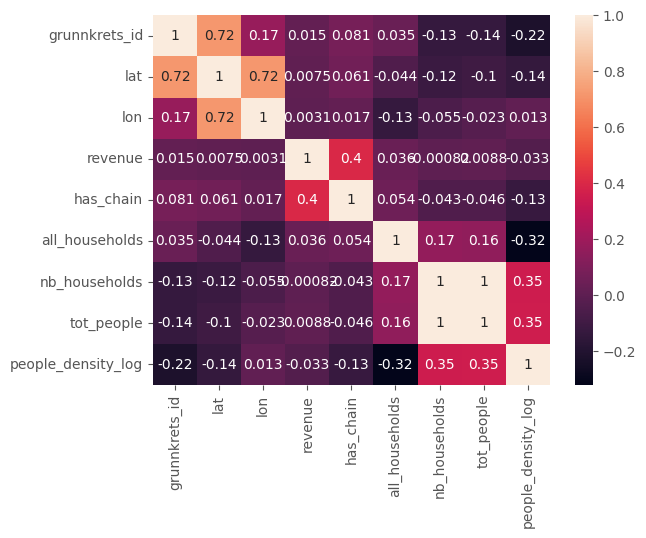

In [306]:
stores_train = pd.read_csv('data/stores_train.csv')
remove_columns(stores_train, ['store_id','store_name','year','address','sales_channel_name'])
stores_train = add_selected_columns(stores_train)
sns.heatmap(stores_train.corr(), annot=True)
plt.show()

In [307]:
stores_train.isnull().sum()

plaace_hierarchy_id        0
grunnkrets_id              0
lat                        0
lon                        0
chain_name                 0
mall_name              10579
revenue                    0
has_chain                  0
municipality_name         30
all_households            33
nb_households            124
tot_people               805
people_density_log       805
dtype: int64

# ___________ _3. Machine Learning Models and Predictions_ ___________


### Helper functions

In [308]:
def convert_DType_LGBM(dFrame):
    le = LabelEncoder()
    X = pd.DataFrame()
    
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        #elif col_name == 'grunnkrets_id':
        #    X[col_name] = le.fit_transform(dFrame[col_name])
        
        else:
            X[col_name] = dFrame[col_name]
    
    return X

In [309]:
def convert_DType_CatBoost(dFrame):
    le = LabelEncoder()
    X = pd.DataFrame()
    for col_name in dFrame:
        
        if col_name == 'grunnkrets_id':
            X[col_name] = dFrame[col_name]
            #X[col_name] = le.fit_transform(dFrame[col_name])
            #X[col_name] = dFrame[col_name].astype(str)
        
        elif col_name == 'mall_name' or col_name == 'chain_name' or col_name == 'municipality_name':
            X[col_name] = dFrame[col_name].astype(str)

        elif dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        else:
            X[col_name] = dFrame[col_name]
    
    return X

Load train data and divide into test and train

In [310]:
def get_data(test_size=0.20):
    stores_train = pd.read_csv('data/stores_train.csv')
    stores_test = pd.read_csv('data/stores_test.csv')

    # select prefered columns
    remove_columns(stores_train, ['store_id','store_name','year','address'])#,'sales_channel_name'])
    remove_columns( stores_test, ['store_id','store_name','year','address'])#,'sales_channel_name'])

    # Add features
    #print(stores_train.shape) 
    stores_train = add_selected_columns(stores_train)
    stores_test = add_selected_columns(stores_test)
    #print(stores_train.shape)

    # Preprocess/Clean data
    #quantile_storeType_vs_revenue(stores_train,0.01, 0.88)

    # Divide data into train and test set
    x_train = stores_train.drop('revenue', axis=1)

    y_train = stores_train['revenue']
    y_train=np.log1p(y_train) #log transform revenue

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, random_state=3)
    
    return  x_train, x_test, y_train, y_test, stores_test


In [311]:
x_train_check, _, _, _, _ = get_data()
print(x_train_check.dtypes)
#x_train_check.head(50)

plaace_hierarchy_id     object
sales_channel_name      object
grunnkrets_id            int64
lat                    float64
lon                    float64
chain_name              object
mall_name               object
has_chain                int64
municipality_name       object
all_households         float64
nb_households          float64
tot_people             float64
people_density_log     float64
dtype: object


#### LightGBM


In [342]:
# Load data
LGBM_x_train, LGBM_x_test, y_train, y_test, _ = get_data()

# Convert to approperiate dtypes
LGBM_x_train = convert_DType_LGBM(LGBM_x_train)
LGBM_x_test = convert_DType_LGBM(LGBM_x_test)



# Make model, fit and predict
parameters = {# Params obtained trough testing and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
              #'metric': 'acc',
              #'n_estimators' : 400
              #'path_smooth' : 0.5,
              #'min_data_in_leaf' : 3
}

LGBM_model = LGBMRegressor(**parameters)
LGBM_model.fit(LGBM_x_train, y_train)
LGBM_pred = LGBM_model.predict(LGBM_x_test)
LGBM_pred=np.expm1(LGBM_pred) #invert log transform

# Run some tests
number_of_negatives = 0
for i in range(len(LGBM_pred)):
    if LGBM_pred[i] < 0.0:
        number_of_negatives += 1
        LGBM_pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,LGBM_pred)}")

number of negatives: 0
rmsle: 0.908385329815001


In [313]:
# Previous rmse scores gave the following kaggle scores:
# - 0.9055645241057166 rmsle resulted in: 0.71576 on kaggle - LGBM a lot of columns)

#### Catboost

In [343]:
# Load data
CB_x_train, CB_x_test, y_train, y_test, _ = get_data()

# Convert to approperiate dtypes
CB_x_train = convert_DType_CatBoost(CB_x_train)
CB_x_test = convert_DType_CatBoost(CB_x_test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )
print(categorical_features_indices)
print(CB_x_train.dtypes)

# Make model, fit and predict
parameters = {}#'depth': 6, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1} # params found with gridsearch in the model interpretation part

CB_model = cb.CatBoostRegressor(loss_function='RMSE', **parameters, verbose=0)
CB_model.fit( CB_x_train, y_train, cat_features=categorical_features_indices, eval_set=test_pool, use_best_model=True)
CB_pred = CB_model.predict(CB_x_test)
CB_pred = np.expm1(CB_pred)


# Run some tests
number_of_negatives = 0
for i in range(len(CB_pred)):
    if CB_pred[i] < 0.0:
        number_of_negatives += 1
        CB_pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,CB_pred)}")


[0 1 5 6 8]
plaace_hierarchy_id    category
sales_channel_name     category
grunnkrets_id             int64
lat                     float64
lon                     float64
chain_name               object
mall_name                object
has_chain                 int64
municipality_name        object
all_households          float64
nb_households           float64
tot_people              float64
people_density_log      float64
dtype: object
number of negatives: 0
rmsle: 0.881161105273642


compare models

In [344]:
compare_preds = pd.DataFrame()
compare_preds['true'] = y_test
compare_preds['mean'] = (CB_pred+LGBM_pred)/2
compare_preds['catboost'] = CB_pred
compare_preds['CB err'] = np.abs(CB_pred - y_test)
compare_preds['lightgbm'] = LGBM_pred
compare_preds['LGBM err'] = np.abs(LGBM_pred - y_test)

print(f" CB err sum: {np.sum(compare_preds['CB err'])}")
print(f" CB err mean: {np.mean(compare_preds['CB err'])}")
print(f" LGBM err sum: {np.sum(compare_preds['LGBM err'])}")
print(f" LGBM err mean: {np.mean(compare_preds['LGBM err'])}")
print(f" RSMLE LGBM: {rmsle(y_test, LGBM_pred)}")
print(f" RSMLE CB: {rmsle(y_test, CB_pred)}")
print(f" RSMLE mean: {rmsle(y_test, ((CB_pred + LGBM_pred)/2))}")


#compare_preds.head(50)

 CB err sum: 10679.163480834039
 CB err mean: 4.152085334694417
 LGBM err sum: 11722.136270461697
 LGBM err mean: 4.557595750568312
 RSMLE LGBM: 0.908385329815001
 RSMLE CB: 0.881161105273642
 RSMLE mean: 0.8944269292605261


## Predict test and submit

In [316]:
# Load data
x_train, _, y_train, _, test = get_data(test_size=0.1)

# Convert to approperiate dtypes
LGBM_x_train = convert_DType_LGBM(x_train)
LGBM_test = convert_DType_LGBM(test)

CB_x_train = convert_DType_CatBoost(x_train)
CB_test = convert_DType_CatBoost(test)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
test_pool = cb.Pool(CB_x_test, y_test, categorical_features_indices )

# LGBM
LGBM_model = LGBMRegressor(**parameters)
LGBM_model.fit(LGBM_x_train, y_train)
LGBM_pred = LGBM_model.predict(LGBM_test)
LGBM_pred=np.expm1(LGBM_pred) #invert log transform

# Catboost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', **parameters, silent=True)
CB_model.fit(CB_x_train,y_train, cat_features=categorical_features_indices, eval_set=test_pool, use_best_model=True)
CB_pred = CB_model.predict(CB_test)
CB_pred = np.expm1(CB_pred)

# Aggregate result
PREDICTION = (CB_pred + LGBM_pred)/2

In [317]:
stores_test = pd.read_csv('data/stores_test.csv')
#write the predicition to file
writeResultToFile(stores_test, PREDICTION, "CB_and_LGBM_Mean")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/CB_and_LGBM_Mean.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


## Old stuff

In [318]:
""" cb_x_train = x_train
categorical_features_indices = np.where((cb_x_train.dtypes != np.float))[0]
cb_x_train = convert_DType_CatBoost(cb_x_train)

cb_x_test = test
cb_x_test = convert_DType_CatBoost(cb_x_test)

CB_model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

CB_model.fit(cb_x_train,y_train, cat_features=categorical_features_indices)
CB_pred = CB_model.predict(cb_x_test)
 """


" cb_x_train = x_train\ncategorical_features_indices = np.where((cb_x_train.dtypes != np.float))[0]\ncb_x_train = convert_DType_CatBoost(cb_x_train)\n\ncb_x_test = test\ncb_x_test = convert_DType_CatBoost(cb_x_test)\n\nCB_model = cb.CatBoostRegressor(loss_function='RMSE')\ngrid = {'iterations': [100, 150, 200],\n        'learning_rate': [0.03, 0.1],\n        'depth': [2, 4, 6, 8],\n        'l2_leaf_reg': [0.2, 0.5, 1, 3]}\n\nCB_model.fit(cb_x_train,y_train, cat_features=categorical_features_indices)\nCB_pred = CB_model.predict(cb_x_test)\n "

## _____ Random Forest Regressor _____

Random Forest Regressor is a model we expirimented with in the beginning but stopped developing as we saw much better results with catboost and lightgbm, the code below i commented out as it is unneccesary to run, but kept in the notebook to show how the project has evolved.

Load, preprocess and convert data to correct format

In [319]:
""" # Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])

 """

" # Load training and test data\nstores_train = pd.read_csv('data/stores_train.csv')\nstores_test = pd.read_csv('data/stores_test.csv')\n\n# Preprocess/Clean data\nremove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])\nremove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])\n#remove_retailers_with_0_revenue(stores_train)\nquantile_storeType_vs_revenue(stores_train,0.10, 0.80)\n\n# Divide data into x and y train\nx_train = stores_train.drop('revenue', axis=1)\ny_train = stores_train['revenue']\nx_test = stores_test.copy()\n\n# Convert from object type to numerical\n#train set\ncat_columns = x_train.select_dtypes(['object']).columns\nx_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])\n#test set\ncat_columns = x_test.select_dtypes(['object']).columns\nx_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])\n\n "

In [320]:
""" stores_train.head() """

' stores_train.head() '

Train model

In [321]:
""" # Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train) """


' # Model\nRFR = RandomForestRegressor(n_estimators=100)\n\n# Fitting\nRFR.fit(x_train, y_train) '

Test RFR model

In [322]:
""" # predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train)) """

' # predicting the training data set as a pin pointer\npred_train_RFR = RFR.predict(x_train)\nprint(rmsle(y_train, pred_train_RFR))\nprint(RFR.score(x_train, y_train)) '

Predict test and submit

In [323]:
""" pred_test_RFR = RFR.predict(x_test) """

' pred_test_RFR = RFR.predict(x_test) '

In [324]:
""" # Write to file
#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
#submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
#submissionVery.info() """

' # Write to file\n#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")\n\n# Verify format of submission file\n#submissionVery = pd.read_csv(\'submissionFiles/RFR_10_80_percentile.csv\')\n#submissionVery.info() '

## Emil modeller

### model 1


In [325]:
# pythons stuff emil

# 4. Model Interpretations

#### Lightgbm


learning_rate                    : 0.02
num_leaves                       : 85
colsample_bytree                 : 0.7017131213364483
subsample                        : 0.8972323471803227
verbosity                        : -1
random_state                     : 42
objective                        : regression
metric                           : l2
num_threads                      : 6
reg_alpha                        : 0.00032890890181318575
min_sum_hessian_in_leaf          : 0.001397812248336808
reg_lambda                       : 6.342674869856521e-05
n_estimators                     : 206


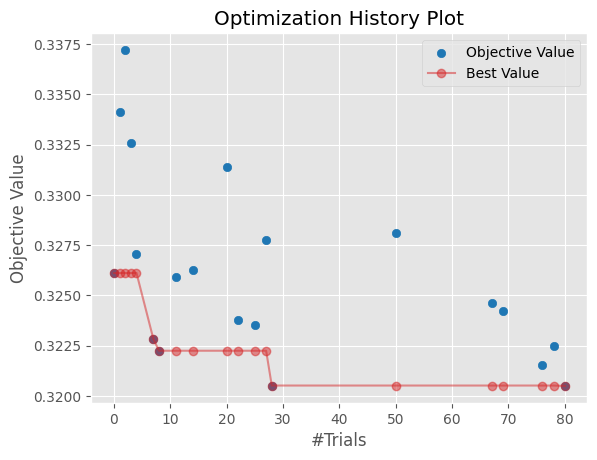

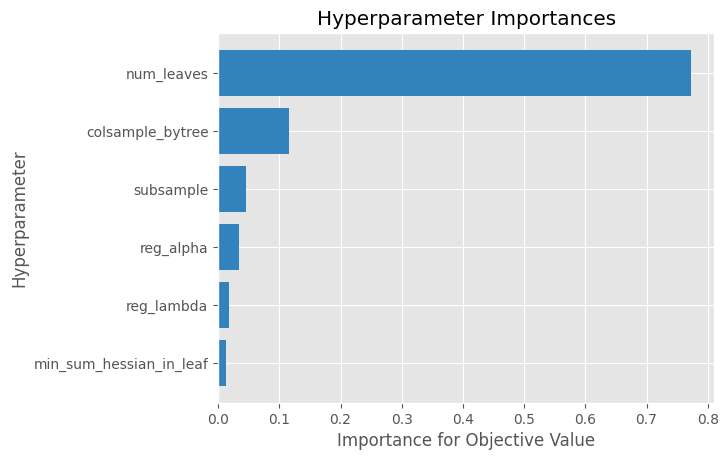

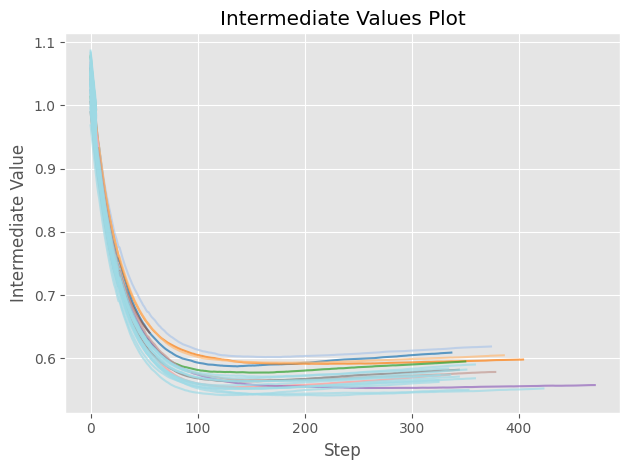

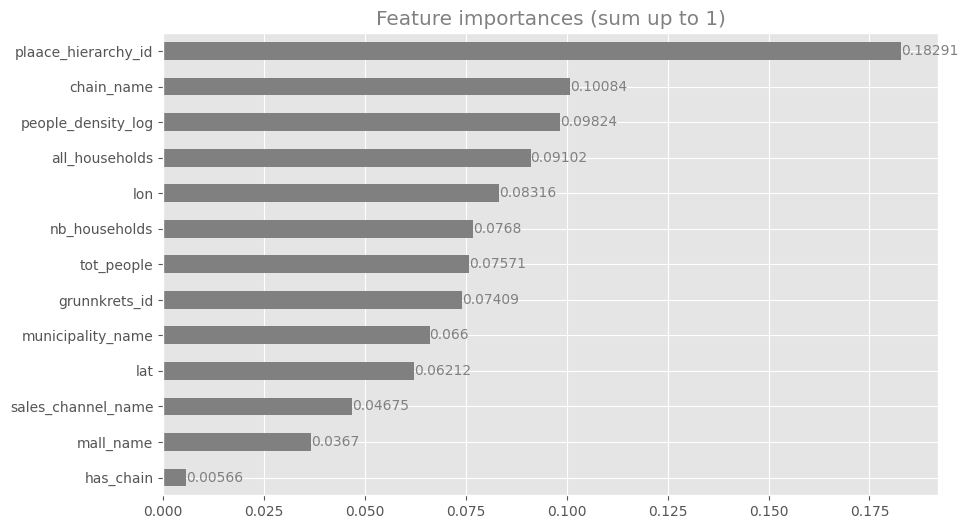



Time elapsed for fit execution: 1 min 35.223 sec


In [326]:
x_train, x_test, y_train, y_test, _ = get_data()
LGBM_x_train = convert_DType_LGBM(x_train)
cat_columns = LGBM_x_train.select_dtypes(['category']).columns
LGBM_x_train[cat_columns] = LGBM_x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])

# Tune
tuner = LGBMTuner(metric = 'rmsle', verbosity=0)
tuner.fit(LGBM_x_train, y_train)



CatBoost

In [330]:
CB_x_train = convert_DType_CatBoost(x_train)
categorical_features_indices = np.where((CB_x_train.dtypes == 'object') | (CB_x_train.dtypes == str) | (CB_x_train.dtypes == 'category') )[0]
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
grid = GridSearchCV(estimator=CB_model, param_grid=grid, cv=2, n_jobs=1, verbose=0)
grid.fit(CB_x_train, y_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd7e79c1970>,
             n_jobs=1,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [100, 150, 200],
                         'l2_leaf_reg': [0.2, 0.5, 1, 3],
                         'learning_rate': [0.03, 0.1]})

In [332]:
grid.best_params_

{'depth': 8, 'iterations': 200, 'l2_leaf_reg': 0.2, 'learning_rate': 0.03}

### Lime

In [ ]:
#lime stuff in python

### Feature importance

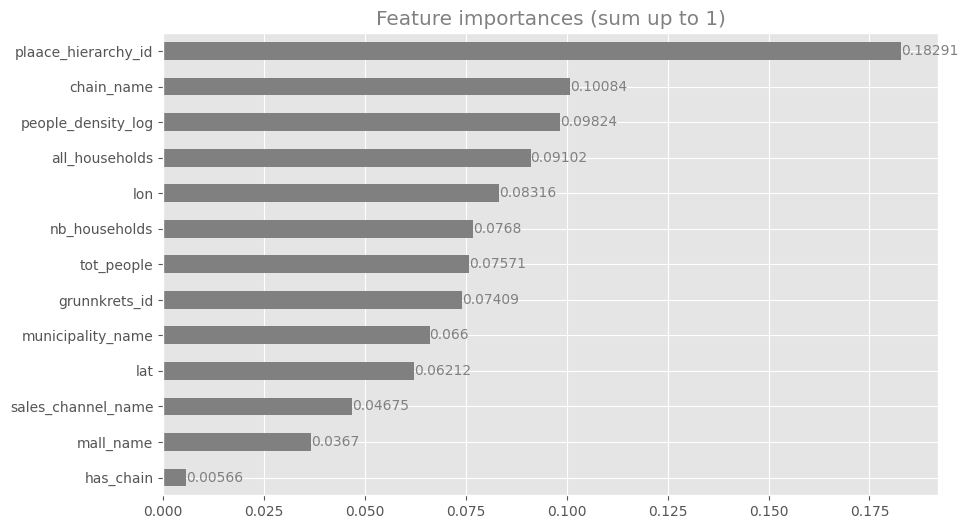

Text(0.5, 1.0, 'Feature Importance')

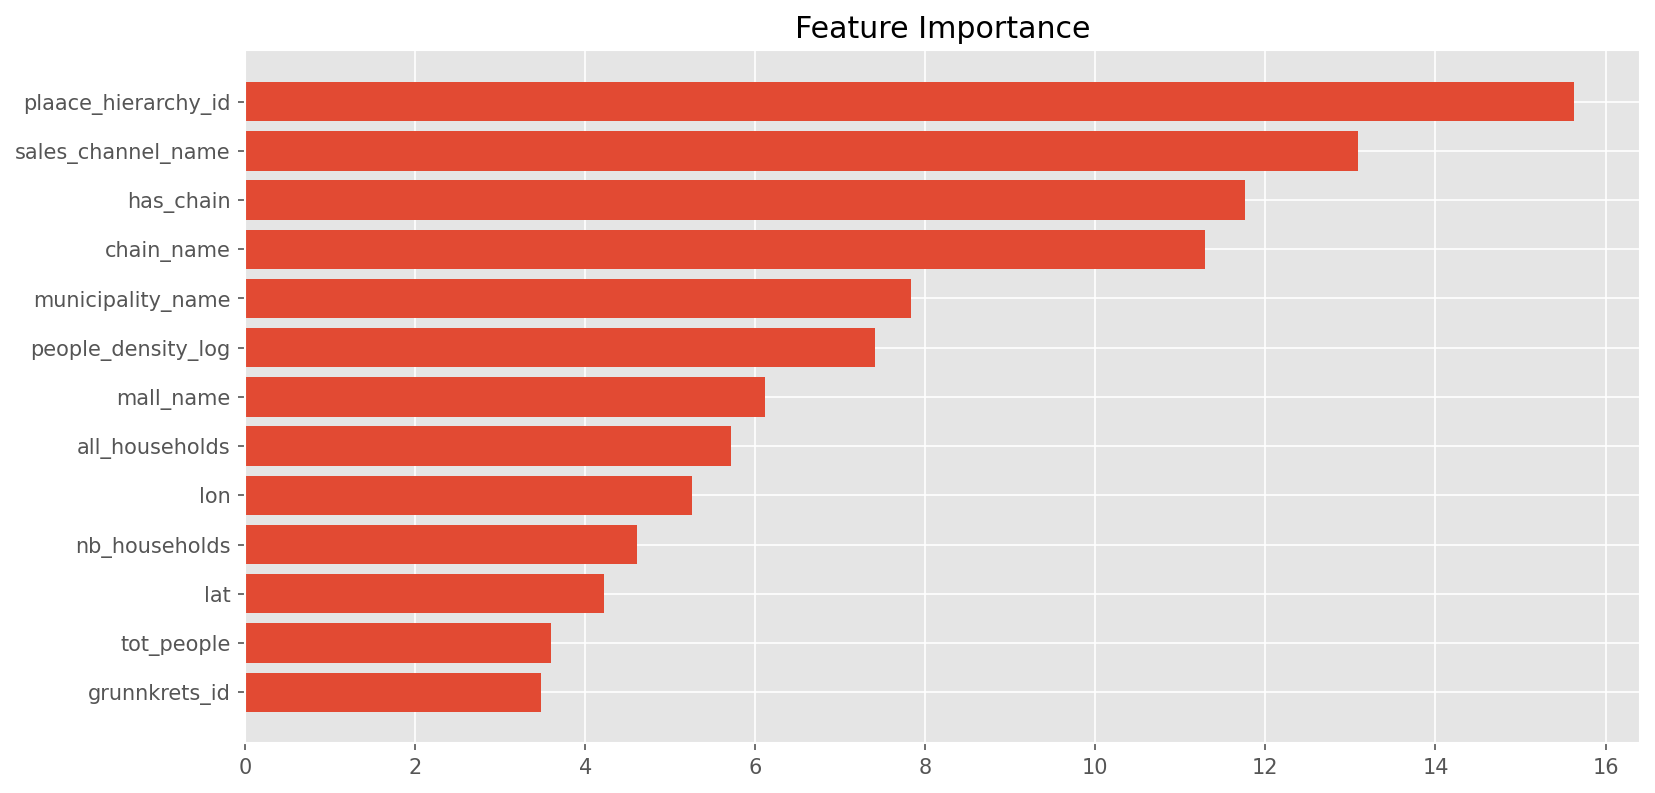

In [331]:
# Feature importance

# lightGBM
tuner.plot_importances()

# catBoost
CB_model = cb.CatBoostRegressor(loss_function='RMSE', verbose=0, cat_features=categorical_features_indices)
CB_model.fit(CB_x_train, y_train)
CB_f_imp = CB_model.feature_importances_
sorted_idx = np.argsort(CB_f_imp)
fig = plt.figure(figsize=(12, 6), dpi=150)
plt.barh(range(len(sorted_idx)), CB_f_imp[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')


### PDP

In [ ]:
#PDP

# 5. Final improved models/predictions

### model 1

In [ ]:
#final model 1

### model 2

In [ ]:
#final model 2

# Testing


#### RMSLE

In [ ]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
